[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebascarag/AI-SyntheticSound/blob/main/TSNE%20Urbansound8K.ipynb)

# Imports

In [1]:
import os
import h5py
import time
import numpy as np
import pandas as pd
import re as regex
from google.colab import files
from sklearn.manifold import TSNE
from sklearn import preprocessing
from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

!pip install import-ipynb
import import_ipynb
from importlib import reload
if not os.path.exists("/content/Model_VAE.ipynb"): files.upload()
import Model_VAE as m_vae

if not os.path.exists("/content/Model_CVAE.ipynb"): files.upload()
import Model_CVAE as m_cvae


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00


Saving Model_CVAE.ipynb to Model_CVAE.ipynb
Saving Model_VAE.ipynb to Model_VAE.ipynb
importing Jupyter notebook from Model_VAE.ipynb
importing Jupyter notebook from Model_CVAE.ipynb


In [ ]:
## refresh models on cache
import Model_VAE as m_vae
reload(m_vae)
import Model_CVAE as m_cvae
reload(m_cvae)

# Dataset

In [5]:
#files.upload()
with h5py.File('/content/vggish_features_labels.hdf5', 'r') as f:
  # file1 = f.get("data")
  data_file = np.array(f.get("data")).astype(float)

In [6]:
print(data_file.shape)
print(type(data_file))
print(data_file[0][0])
print(min(data_file[0]))
print(max(data_file[0]))

(7077, 513)
<class 'numpy.ndarray'>
166.0
0.0
255.0


In [7]:
# features = preprocessing.normalize(data_file[:,:-1])
# scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(data_file[:,:-1])
print("features", features.shape)
print("features", type(features))
print("value",features[0][0])
print("min", min(features[0]))
print("max",max(features[0]))
labels = data_file[:,-1].astype(int)
print("labels", labels.shape)
print("labels", labels[0])

features (7077, 512)
features <class 'numpy.ndarray'>
value 0.4285714285714286
min 0.0
max 1.0
labels (7077,)
labels 2


In [8]:
dataset = TensorDataset( torch.Tensor(features), torch.Tensor(labels) )

In [10]:
idx, y = next(enumerate(dataset))
print("features:",y[0].shape)
print("features:", y[0][0])
print("label:", y[1])
# print(idx, y)

features: torch.Size([512])
features: tensor(0.4286)
label: tensor(2.)


In [11]:
class_dict = {
  '0':'Amanecer',
  '1':'Dia',
  '2':'Atardecer',
  '3':'Noche',
  '0': 'air_conditioner',
  '1': 'car_horn',
  '2': 'children_playing',
  '3': 'dog_bark',
  '4': 'drilling',
  '5': 'engine_idling',
  '6': 'gun_shot',
  '7': 'jackhammer',
  '8': 'siren',
  '9': 'street_music'
}

In [12]:
start_time_tsne = time.time()

tsne = TSNE(n_components=2,random_state=42)
tsne_results = tsne.fit_transform(features)

fig = px.scatter(
        tsne_results, x=0, y=1,
        color=labels.astype(str),
        labels={'color': 'tipo'}
      )
fig.for_each_trace(lambda t: t.update(name = class_dict[t.name]))
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Total Time: 1.06 min


# Helper funtions

In [43]:
def identifyNet(model):
  cvae = False
  model_name = str(type(model))
  result = regex.search(r"'(.*?)'", model_name)
  model_name = result.group(1)
  if model_name.__contains__('Model_CVAE'):
    print('model CVAE')
    cvae = True
  else:
    print('model VAE')
  return cvae, model_name


def getTrainedLatentVectorAndLabels(trained_model, data, kl_version):
  start_time_pandas = time.time()

  encoded_samples = np.empty([0, latent_dims])
  labels = np.empty([0,1])
  input_imgs = np.empty([0, num_features])

  cvae, model_name = identifyNet(trained_model)

  for features, targets in tqdm(data):
    features = features.to(device)
    targets = targets.type(torch.int64).to(device)

    trained_model.eval()

    with torch.no_grad():
      if cvae:
        encoded_img = trained_model.encoder(features, targets, kl_version)
      else:
        encoded_img = trained_model.encoder(features)

    labels = np.append(labels, targets.cpu().numpy())
    encoded_samples = np.append(encoded_samples, encoded_img.cpu().numpy(), axis=0)
    input_imgs = np.append(input_imgs, features.cpu().numpy(), axis=0)

  print('Total Time: %.2f min' % ((time.time() - start_time_pandas)/60))
  return encoded_samples, labels, input_imgs


def plot_tsne2(trained_model, data, kl_version=2, frac=0, plot_v=1, file_name_to_save='', TSNE_coords=None, TSNE_labels=None):
  if TSNE_coords is None:
    encoded_samples, TSNE_labels, img_inputs = getTrainedLatentVectorAndLabels(trained_model, data, kl_version)

    if frac > 0:
      encoded_samples_df = np.append(encoded_samples, TSNE_labels[:,None], axis=1)
      encoded_samples_df = pd.DataFrame(encoded_samples_df, columns=[f'Variable {i}' for i in range(encoded_samples.shape[1])] + ['label'])
      encoded_samples_df = encoded_samples_df.groupby("label").sample(frac=frac, random_state=random_seed)

      encoded_samples = encoded_samples_df.drop(['label'],axis=1)
      TSNE_labels = encoded_samples_df['label']

    print("ok load data")
    print("start build TSNE")

    start_time_tsne = time.time()
    TSNE_coords = TSNE(n_components=2,random_state=random_seed).fit_transform(encoded_samples)
    print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

  if TSNE_coords is not None and TSNE_labels is None:
    raise Exception("TSNE_labels are required")

  if plot_v == 1:
    fig = px.scatter(
        TSNE_coords, x=0, y=1,
        color=np.array(TSNE_labels).astype(int).astype(str),
        labels={'color': 'tipo'}
      )
    fig.for_each_trace(lambda t: t.update(name = class_dict[t.name]))
    fig.show()
  else:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title('t-SNE')
    plt.scatter(TSNE_coords[:, 0], TSNE_coords[:, 1], c=TSNE_labels)
    plt.colorbar()
    for i in range(10):
      class_center = np.mean(TSNE_coords[TSNE_labels == i], axis=0)
      text = TextArea('{}'.format(i))
      ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
      ax.add_artist(ab)
    if not file_name_to_save == "":
      plt.savefig("plot_tsne/"+file_name_to_save)
    else:
      plt.show()
  return TSNE_coords, TSNE_labels


def plot3D(trained_model, data, kl_version=2, frac=0):
  encoded_samples, labels, img_inputs = getTrainedLatentVectorAndLabels(trained_model, data, kl_version)

  if frac > 0:
    encoded_samples_df = np.append(encoded_samples, labels[:,None], axis=1)
    encoded_samples_df = pd.DataFrame(encoded_samples_df, columns=[f'Variable {i}' for i in range(encoded_samples.shape[1])] + ['label'])
    encoded_samples_df = encoded_samples_df.groupby("label").sample(frac=frac, random_state=random_seed)

    encoded_samples = encoded_samples_df.drop(['label'],axis=1)
    labels = encoded_samples_df['label']

  print("ok load data")
  print("start build TSNE")

  start_time_tsne = time.time()

  tsne_results = TSNE(n_components=3,random_state=42).fit_transform(encoded_samples)

  fig = px.scatter_3d(
          tsne_results, x=0, y=1, z=2,
          color=labels.astype(str),
          labels={'0': 'tsne-one', '1': 'tsne-two', '2': 'tsne-three'}
        )
  fig.show()

  print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))


def plot_losses(val_loss):
  plt.figure(figsize=(15, 5))
  plt.plot(val_loss[:,0], label="loss")
  plt.plot(val_loss[:,1], label="kl", linestyle=":")
  plt.plot(val_loss[:,2], label="pw", linestyle="-.")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

# Save iterative plot TSNE

In [ ]:
max_num_latent = 8#201
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for latent in range(4, max_num_latent, 4):
  print(latent)

  # Hyperparameters
  random_seed = 5
  learning_rate = 0.0001
  num_epochs = 2
  batch_size = 8

  # Architecture
  num_classes = 10
  num_features = 512
  num_hidden = 256
  num_latent = latent
  torch.manual_seed(random_seed)  # garantizar repetibilidad

  # train data
  data = DataLoader( dataset, batch_size = batch_size,
          shuffle = False # importante: para obtener resultados similares al re-ejecutar
        )
  # model
  modelVAE = m_vae.VariationalAutoencoder(
                latent_dims= num_latent,
                num_features= num_features,
                num_hidden_layers= num_hidden
              )
  modelVAE = modelVAE.to(device.type)

  #train
  trained_vae, losses_vae = modelVAE.train_fit(data=data, learning_rate=learning_rate, num_epochs=num_epochs)
  plot_tsne2(trained_vae, data, kl_version=1, frac=0.3, plot_v=2, file_name_to_save='vae-lr[{}]-latent[{}].png'.format(learning_rate, latent))

# Best params VAE

* Best Params by key: {'latent_dims': 42, 'num_hidden_layers': 483, 'learning_rate': 0.0002779903927778435, 'num_epochs': 176}

## batch_size = 4

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 4
latent_dims = 42
num_hidden_layers = 483
num_features = y[0].shape[0]
learning_rate = 0.0002779903927778435
num_epochs= 176

torch.manual_seed(random_seed)
data = DataLoader( dataset, batch_size = 4, shuffle = False)

params = {
    'latent_dims': latent_dims,
    'num_features': num_features,
    'num_hidden_layers': num_hidden_layers,
    'random_seed': random_seed
}
modelVAE = m_vae.VariationalAutoencoder(**params).to(device)

params = {
    'data': data,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs
}
best_model, best_loss, losses = modelVAE.train_fit(**params)

print(best_loss)

Epoch: 106/176 | Batch 704/1769 | kl: 17.4184 + pw: 45.4574 = loss: 62.8758
Epoch: 106/176 | Batch 880/1769 | kl: 18.4323 + pw: 45.4237 = loss: 63.8560
Epoch: 106/176 | Batch 1056/1769 | kl: 18.6854 + pw: 50.8615 = loss: 69.5469
Epoch: 106/176 | Batch 1232/1769 | kl: 17.8882 + pw: 57.6318 = loss: 75.5199
Epoch: 106/176 | Batch 1408/1769 | kl: 16.5425 + pw: 69.5853 = loss: 86.1278
Epoch: 106/176 | Batch 1584/1769 | kl: 16.0354 + pw: 84.1856 = loss: 100.2210
Epoch: 106/176 | Batch 1760/1769 | kl: 14.6166 + pw: 67.8391 = loss: 82.4556
Time elapsed: 0.12 min
Epoch: 107/176 | Batch 000/1769 | kl: 14.1284 + pw: 64.9432 = loss: 79.0716
Epoch: 107/176 | Batch 176/1769 | kl: 19.7836 + pw: 51.7093 = loss: 71.4929
Epoch: 107/176 | Batch 352/1769 | kl: 16.0464 + pw: 81.9019 = loss: 97.9483
Epoch: 107/176 | Batch 528/1769 | kl: 19.4779 + pw: 12.0091 = loss: 31.4870
Epoch: 107/176 | Batch 704/1769 | kl: 16.3621 + pw: 53.3594 = loss: 69.7215
Epoch: 107/176 | Batch 880/1769 | kl: 17.9611 + pw: 44.6144

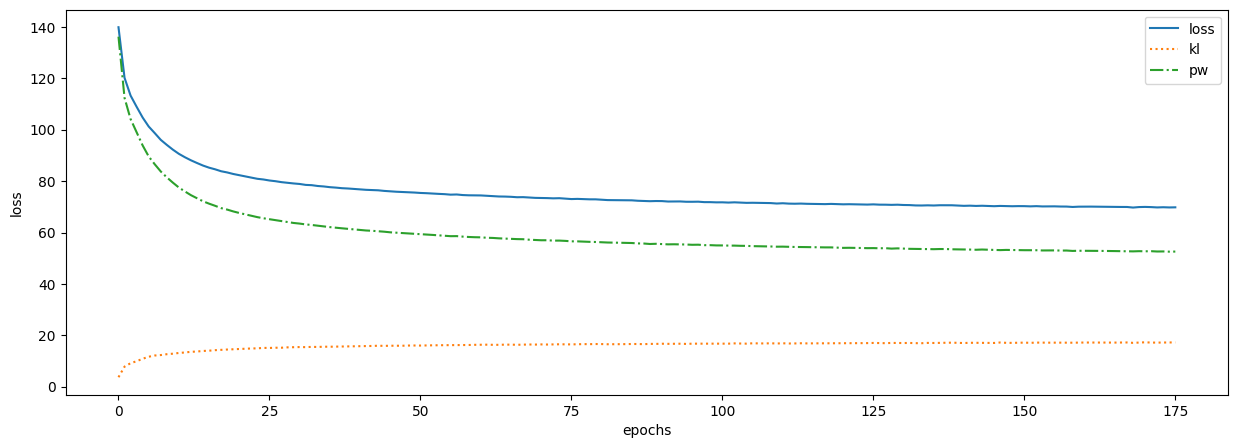

In [22]:
plot_losses(losses)

In [41]:
tsne = plot_tsne2(best_model, data, plot_v=1)

model VAE


100%|██████████| 1770/1770 [00:06<00:00, 270.82it/s]


Total Time: 0.11 min
ok load data
start build TSNE
Total Time: 1.27 min


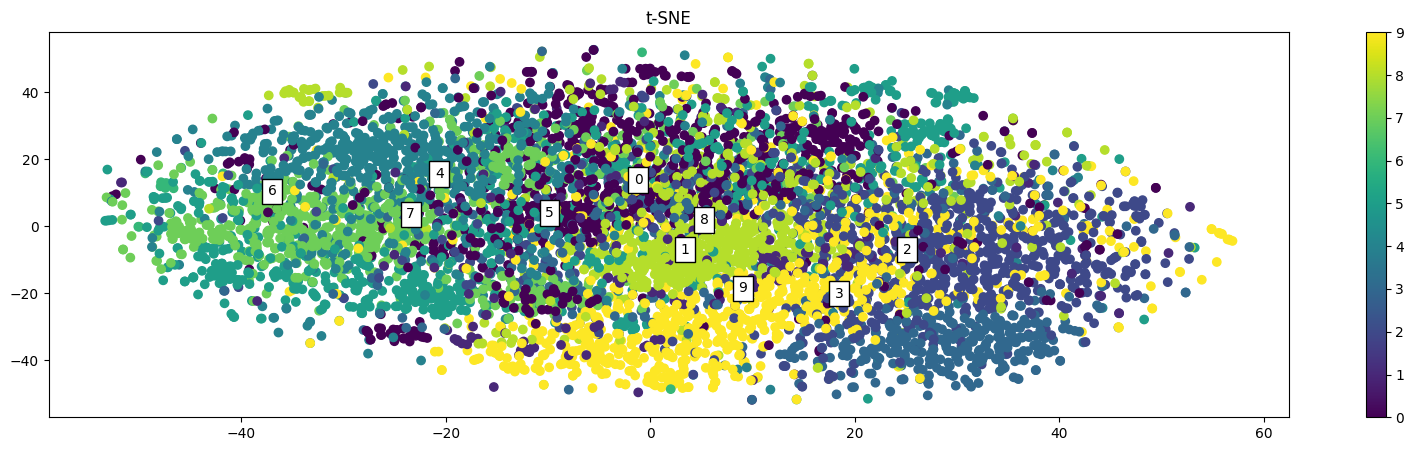

In [44]:
_ = plot_tsne2(best_model, data, plot_v=2, TSNE_coords=tsne[0], TSNE_labels=tsne[1])

## batch_size = 8

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 4
latent_dims = 42
num_hidden_layers = 483
num_features = y[0].shape[0]
learning_rate = 0.0002779903927778435
num_epochs= 176

torch.manual_seed(random_seed)
data = DataLoader( dataset, batch_size = 8, shuffle = False)

params = {
    'latent_dims': latent_dims,
    'num_features': num_features,
    'num_hidden_layers': num_hidden_layers,
    'random_seed': random_seed
}
modelVAE = m_vae.VariationalAutoencoder(**params).to(device)

params = {
    'data': data,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs
}
best_model, best_loss, losses = modelVAE.train_fit(**params)

print(best_loss)

Device: cuda:0
Epoch: 001/176 | Batch 000/884 | kl: 0.8507 + pw: 380.4203 = loss: 381.2710
Epoch: 001/176 | Batch 176/884 | kl: 1.6647 + pw: 329.6158 = loss: 331.2805
Epoch: 001/176 | Batch 352/884 | kl: 5.2113 + pw: 269.3337 = loss: 274.5450
Epoch: 001/176 | Batch 528/884 | kl: 3.6451 + pw: 277.1806 = loss: 280.8257
Epoch: 001/176 | Batch 704/884 | kl: 6.9391 + pw: 228.0551 = loss: 234.9942
Epoch: 001/176 | Batch 880/884 | kl: 8.6449 + pw: 173.9694 = loss: 182.6143
Time elapsed: 0.06 min
Epoch: 002/176 | Batch 000/884 | kl: 11.4361 + pw: 226.6363 = loss: 238.0724
Epoch: 002/176 | Batch 176/884 | kl: 12.1499 + pw: 264.9852 = loss: 277.1351
Epoch: 002/176 | Batch 352/884 | kl: 12.0686 + pw: 221.9848 = loss: 234.0533
Epoch: 002/176 | Batch 528/884 | kl: 9.1791 + pw: 248.2401 = loss: 257.4192
Epoch: 002/176 | Batch 704/884 | kl: 10.9574 + pw: 213.8161 = loss: 224.7734
Epoch: 002/176 | Batch 880/884 | kl: 9.7304 + pw: 170.8720 = loss: 180.6024
Time elapsed: 0.05 min
Epoch: 003/176 | Batch 

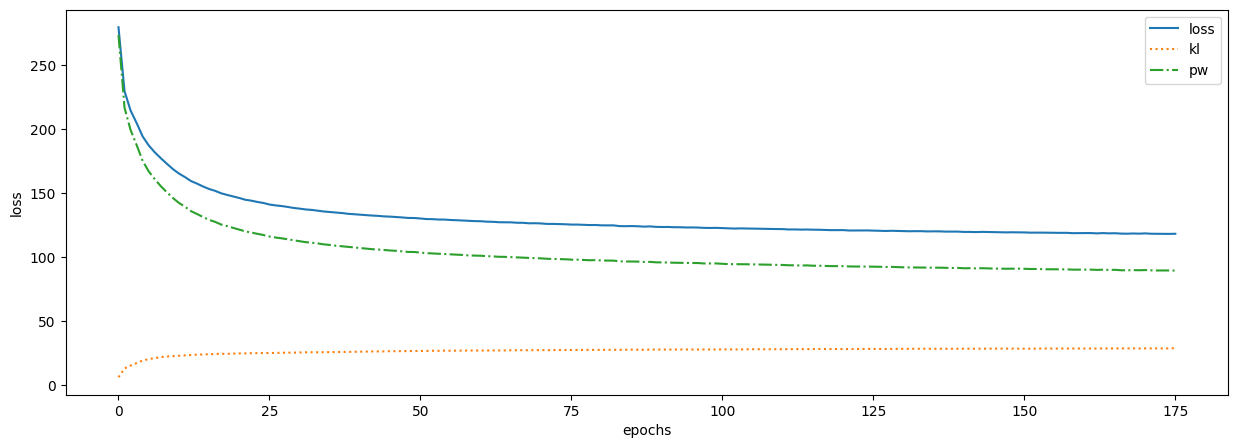

In [46]:
plot_losses(losses)

In [47]:
tsne = plot_tsne2(best_model, data, plot_v=1)

model VAE


100%|██████████| 885/885 [00:03<00:00, 278.91it/s]


Total Time: 0.05 min
ok load data
start build TSNE
Total Time: 1.08 min


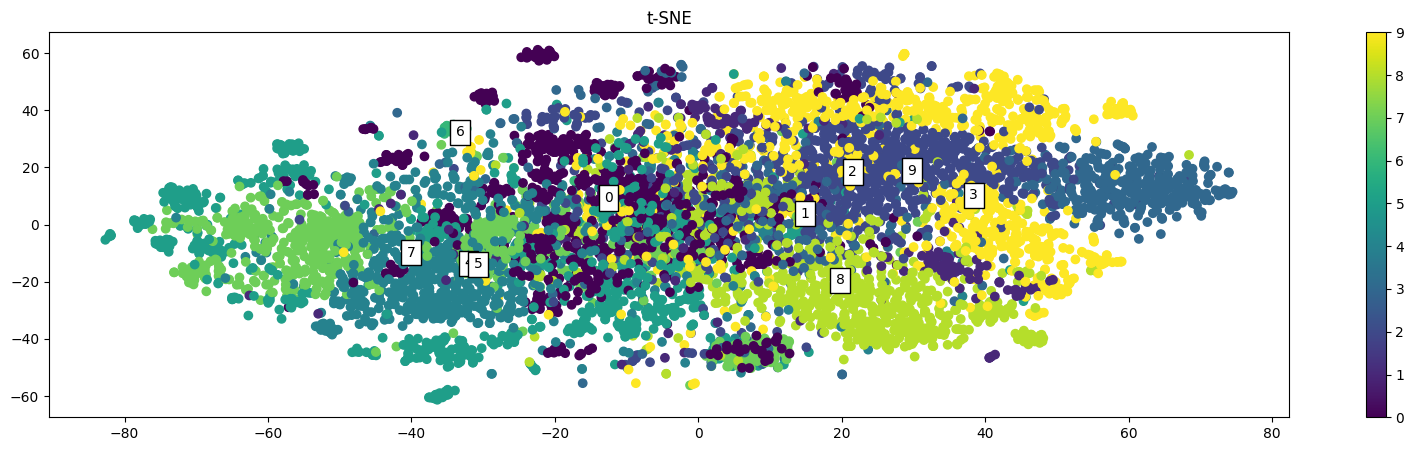

In [49]:
_ = plot_tsne2(best_model, data, plot_v=2, TSNE_coords=tsne[0], TSNE_labels=tsne[1])

# Best params CVAE

* Best Params by key: {'latent_dims': 8, 'num_hidden_layers': 490, 'learning_rate': 0.0006786873927231535, 'num_epochs': 180}

## batch_size = 4

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 4
latent_dims = 8
num_hidden_layers = 490
num_features = y[0].shape[0]
num_classes = len(class_dict)
learning_rate = 0.0006786873927231535
num_epochs= 180

torch.manual_seed(random_seed)
data = DataLoader( dataset, batch_size = 4, shuffle = False)

params = {
    'latent_dims': latent_dims,
    'num_features': num_features,
    'num_hidden_layers': num_hidden_layers,
    'num_classes': num_classes,
    'random_seed': random_seed
}
modelCVAE = m_cvae.ConditionalVariationalAutoencoder(**params).to(device)

params = {
    'data': data,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'kl_version': 2
}
best_model, best_loss, losses = modelCVAE.train_fit(**params)

print(best_loss)

Device: cuda:0
Epoch: 001/180 | Batch 000/1769 | kl: 0.2283 + pw: 1455.3892 = loss: 1455.6174 | KL v02
Epoch: 001/180 | Batch 180/1769 | kl: 1.2557 + pw: 1370.9519 = loss: 1372.2076 | KL v02
Epoch: 001/180 | Batch 360/1769 | kl: 1.2347 + pw: 1258.7025 = loss: 1259.9373 | KL v02
Epoch: 001/180 | Batch 540/1769 | kl: 3.2154 + pw: 1294.9265 = loss: 1298.1420 | KL v02
Epoch: 001/180 | Batch 720/1769 | kl: 2.8175 + pw: 1296.5161 = loss: 1299.3336 | KL v02
Epoch: 001/180 | Batch 900/1769 | kl: 4.6099 + pw: 1287.4601 = loss: 1292.0701 | KL v02
Epoch: 001/180 | Batch 1080/1769 | kl: 4.6803 + pw: 1509.1666 = loss: 1513.8469 | KL v02
Epoch: 001/180 | Batch 1260/1769 | kl: 23.0388 + pw: 1013.5736 = loss: 1036.6124 | KL v02
Epoch: 001/180 | Batch 1440/1769 | kl: 16.2884 + pw: 1086.0693 = loss: 1102.3578 | KL v02
Epoch: 001/180 | Batch 1620/1769 | kl: 2.7758 + pw: 1226.4543 = loss: 1229.2301 | KL v02
Time elapsed: 0.09 min
Epoch: 002/180 | Batch 000/1769 | kl: 4.5464 + pw: 1256.0756 = loss: 1260.62

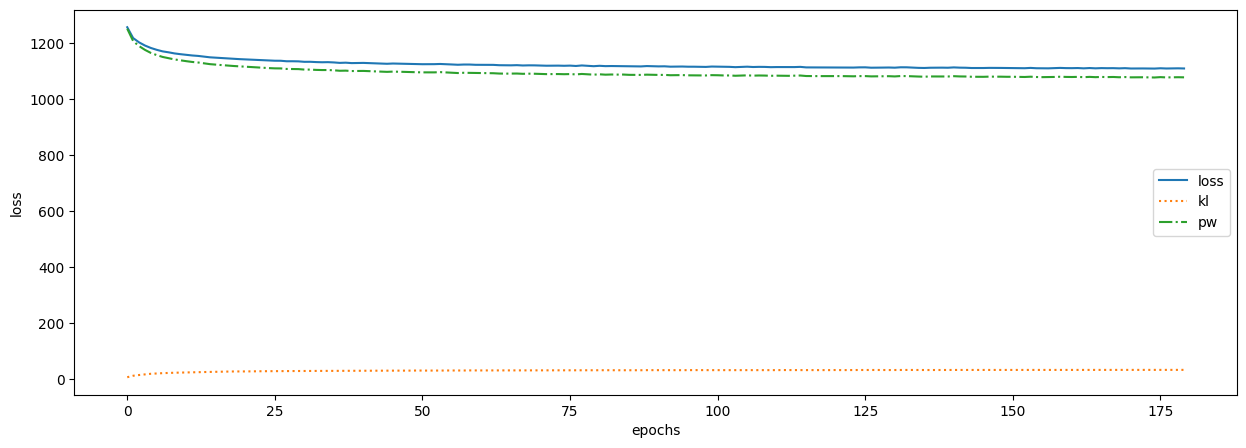

In [55]:
plot_losses(losses)

In [56]:
tsne = plot_tsne2(best_model, data, plot_v=1)

model CVAE


100%|██████████| 1770/1770 [00:05<00:00, 340.42it/s]


Total Time: 0.09 min
ok load data
start build TSNE
Total Time: 0.81 min


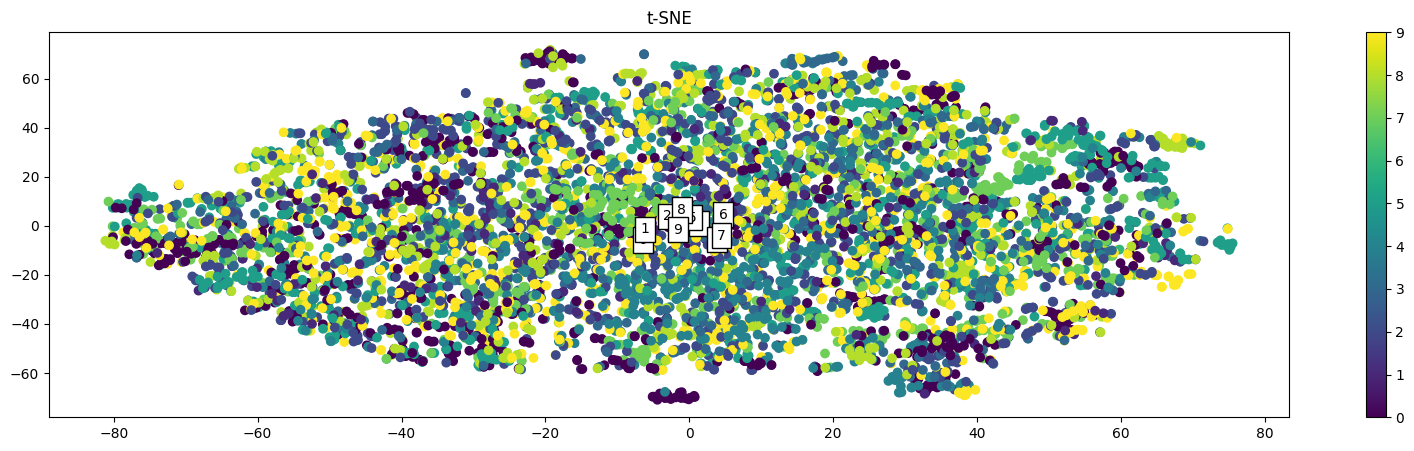

In [57]:
_ = plot_tsne2(best_model, data, plot_v=2, TSNE_coords=tsne[0], TSNE_labels=tsne[1])

## batch_size = 8

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 4
latent_dims = 8
num_hidden_layers = 490
num_features = y[0].shape[0]
num_classes = len(class_dict)
learning_rate = 0.0006786873927231535
num_epochs= 180

torch.manual_seed(random_seed)
data = DataLoader( dataset, batch_size = 8, shuffle = False)

params = {
    'latent_dims': latent_dims,
    'num_features': num_features,
    'num_hidden_layers': num_hidden_layers,
    'num_classes': num_classes,
    'random_seed': random_seed
}
modelCVAE = m_cvae.ConditionalVariationalAutoencoder(**params).to(device)

params = {
    'data': data,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'kl_version': 2
}
best_model, best_loss, losses = modelCVAE.train_fit(**params)

print(best_loss)

Device: cuda:0
Epoch: 001/180 | Batch 000/884 | kl: 0.4527 + pw: 2911.7241 = loss: 2912.1768 | KL v02
Epoch: 001/180 | Batch 180/884 | kl: 2.1875 + pw: 2492.7866 = loss: 2494.9741 | KL v02
Epoch: 001/180 | Batch 360/884 | kl: 6.7393 + pw: 2612.1611 = loss: 2618.9004 | KL v02
Epoch: 001/180 | Batch 540/884 | kl: 12.9934 + pw: 2973.9766 = loss: 2986.9700 | KL v02
Epoch: 001/180 | Batch 720/884 | kl: 8.5910 + pw: 2230.0127 = loss: 2238.6038 | KL v02
Time elapsed: 0.05 min
Epoch: 002/180 | Batch 000/884 | kl: 9.2077 + pw: 2502.9683 = loss: 2512.1760 | KL v02
Epoch: 002/180 | Batch 180/884 | kl: 23.7749 + pw: 2347.8499 = loss: 2371.6248 | KL v02
Epoch: 002/180 | Batch 360/884 | kl: 26.5783 + pw: 2393.7812 = loss: 2420.3596 | KL v02
Epoch: 002/180 | Batch 540/884 | kl: 22.7316 + pw: 2946.8232 = loss: 2969.5549 | KL v02
Epoch: 002/180 | Batch 720/884 | kl: 52.4874 + pw: 1996.5046 = loss: 2048.9919 | KL v02
Time elapsed: 0.05 min
Epoch: 003/180 | Batch 000/884 | kl: 16.3048 + pw: 2492.5422 = l

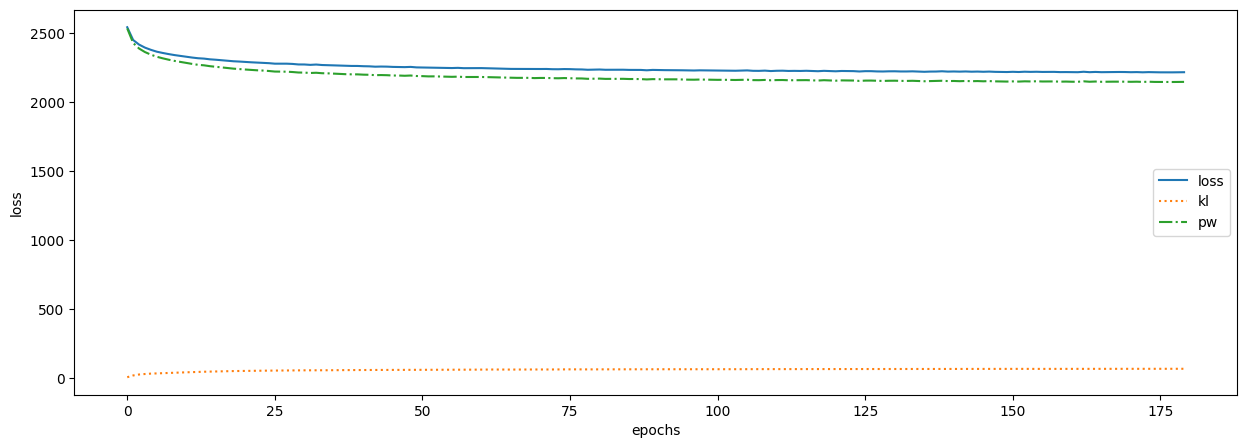

In [59]:
plot_losses(losses)

In [60]:
tsne = plot_tsne2(best_model, data, plot_v=1)

model CVAE


100%|██████████| 885/885 [00:02<00:00, 329.20it/s]


Total Time: 0.04 min
ok load data
start build TSNE


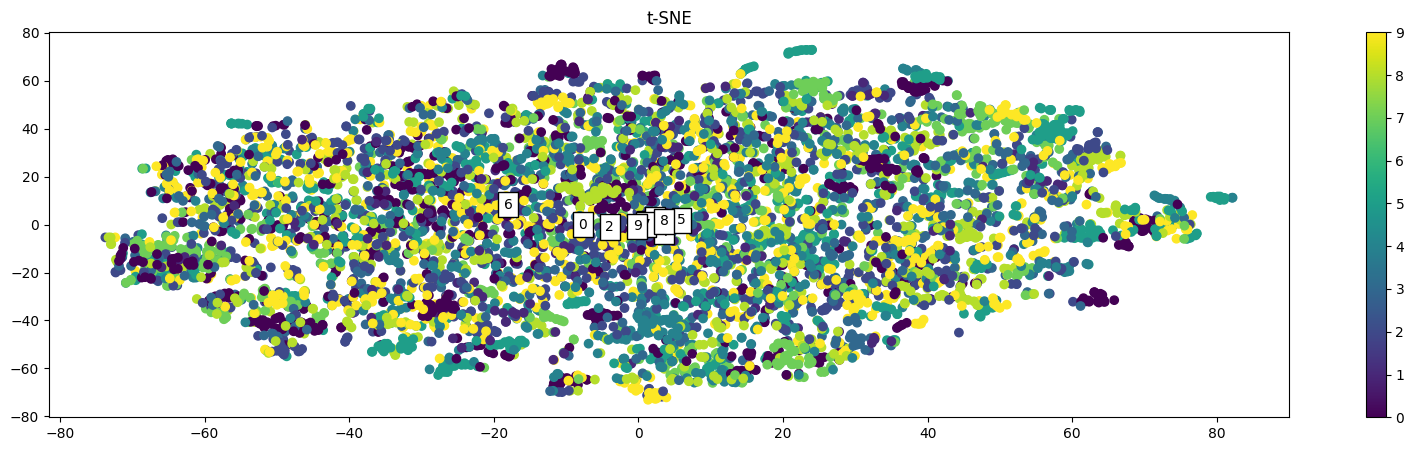

In [61]:
_ = plot_tsne2(best_model, data, plot_v=2, TSNE_coords=tsne[0], TSNE_labels=tsne[1])